### NLP Algorithm for ChatGPT Sentiment

**Author: Mark Peng** 


Purpose of the analysis:


- [Data Exploration](#-Data-Exploration)
- [Data Cleansing](#-Data-Cleansing)
- [Problem 3](#-Problem-3)
- [Problem 4](#-Problem-4)
- [Problem 5](#-Problem-5)

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.base import TransformerMixin
from time import time
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

[Back to top](#-Index)

### Data Exploration

#### In this section, we are going to explore the data and perform some simple Exploratory Data Analysis

#### I am using the ChatGPT sentiment analysis data: https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis/

In [13]:
df = pd.read_csv('file.csv')
df=df.iloc[:,1:]

In [15]:
df.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [16]:
df.groupby('labels').size()

labels
bad        107796
good        56011
neutral     55487
dtype: int64

In [17]:
# We transform the problem to only look at Good and Bad and classify good vs bad
df=df[df.labels.isin(['good','bad'])]

In [18]:
df.head()

,tweets,labels
1,"Try talking with ChatGPT, our new AI system wh...",good
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
5,"Just launched ChatGPT, our new AI system which...",good
6,"As of 2 minutes ago, @OpenAI released their ne...",bad


[Back to top](#-Index)

### Data Cleansing

#### In this section, we are going to clean the data 

In [21]:
for i in df.tweets.head(5):
    print(i)

Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr
THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71
As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1
Just launched ChatGPT, our new AI system which is optimized for dialogue: https://t.co/ArX6m0FfLE.\n\nTry it out here: https://t.co/YM1gp5bA64
As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now \n \nhttps://t.co/kUcnWYhQ1b\n\n🤯 https://t.co/kCE59Xs0YG https://t.co/cSn5h6h1M1


In [22]:
# We are seeing website address here. Therefore, we are going to remove tweet link that start with https:
df['tweet_new'] = df['tweets'].str.replace('https:.*','')


/var/folders/15/zmd7cx2538151mv3b5ftl2680000gp/T/ipykernel_46390/239895155.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_new'] = df['tweets'].str.replace('https:.*','')


In [23]:
for i in df.tweet_new.head(5):
    print(i)

Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. 
THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. 
As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now 👇 
Just launched ChatGPT, our new AI system which is optimized for dialogue: 
As of 2 minutes ago, @OpenAI released their new ChatGPT. \n\nAnd you can use it right now \n \n


In [24]:
# Next we want to remove any non-alphanumber character
df['tweet_new'] = df['tweet_new'].str.replace('[^a-zA-Z0-9]',' ')

/var/folders/15/zmd7cx2538151mv3b5ftl2680000gp/T/ipykernel_46390/1344358253.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['tweet_new'] = df['tweet_new'].str.replace('[^a-zA-Z0-9]',' ')


In [25]:
for i in df.tweet_new.head(5):
    print(i)

Try talking with ChatGPT  our new AI system which is optimized for dialogue  Your feedback will help us improve it  
THRILLED to share that ChatGPT  our new model optimized for dialog  is now public  free  and accessible to everyone  
As of 2 minutes ago   OpenAI released their new ChatGPT   n nAnd you can use it right now   
Just launched ChatGPT  our new AI system which is optimized for dialogue  
As of 2 minutes ago   OpenAI released their new ChatGPT   n nAnd you can use it right now  n  n


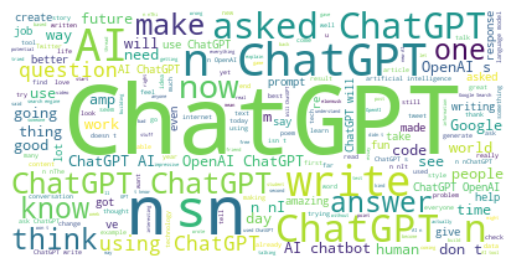

In [59]:
# text=df.tweet_new[1]     #Single Review to test out
text=" ".join(tweet for tweet in df.tweet_new)
stopwords= set(STOPWORDS)
wordclod=WordCloud(stopwords=stopwords, background_color='white').generate(text)
plt.imshow(wordclod, interpolation='bilinear')
plt.axis('off')
plt.show()

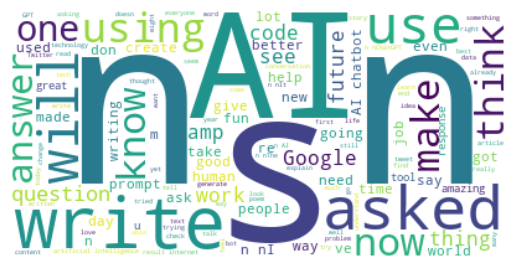

In [62]:
#update the stopwords
stopwords.update(['ChatGPT', 'chatgpt', 'CHATGPT', 'OpenAI'])
wordclod=WordCloud(stopwords=stopwords, background_color='white').generate(text)
plt.imshow(wordclod, interpolation='bilinear')
plt.axis('off')
plt.show()

In [80]:
# Label Encoder to encode Target variable (this is needed for XGboost Classifier)
le=LabelEncoder()
df['target_encoded']=le.fit_transform(df.labels)
# le.classes_

In [82]:
X = df['tweet_new']
y = df['target_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### Logistics Navie Bayes

In [91]:
# define the classifier that we would like to train
names = [
    "Logistics Regression",
    "Nearest Neighbors",
    "Decision Tree",
    "Multinoimal Navie Bayes",
    "Random Forest",
    "XGBoost"
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    MultinomialNB(),
    RandomForestClassifier(max_depth=20, oob_score=True),
    XGBClassifier()
]

In [92]:
Model=[]
ACC_Model=[]
CLF_List=[]
Run_Time=[]

In [94]:
# For loop for all the mdoel on TF-IDF
for name, clf in zip(names,classifiers):
    model_start=time()
    clf_pipe=Pipeline([ 
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('classifiers', clf)
    ])
    clf_pipe.fit(X_train, y_train)
    time_took=time()-model_start
    test_acc = clf_pipe.score(X_test, y_test)
    Model.append(name)
    CLF_List.append(clf_pipe)
    ACC_Model.append(test_acc)
    Run_Time.append(time_took)


/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
# For loop for model on word count
for name, clf in zip(names,classifiers):
    model_start=time()
    clf_pipe=Pipeline([ 
                ('counttv', CountVectorizer(stop_words='english')),
                ('classifiers', clf)
    ])
    clf_pipe.fit(X_train, y_train)
    time_took=time()-model_start
    test_acc = clf_pipe.score(X_test, y_test)
    Model.append(name)
    CLF_List.append(clf_pipe)
    ACC_Model.append(test_acc)
    Run_Time.append(time_took)

/Users/markpeng/.pyenv/versions/3.8.15/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
compare_df=pd.DataFrame(
    {'Model': Model,
     'Standardization': 'TF-IDF',
    'Testing Accuracy': ACC_Model,
       'Run Time': [abs(i) for i in Run_Time]   }
)
compare_df.loc[6:,'Standardization']='Word Count'

In [104]:
compare_df

,Model,Standardization,Testing Accuracy,Run Time
0,Logistics Regression,TF-IDF,0.951480,2.252855
1,Nearest Neighbors,TF-IDF,0.718011,1.099999
2,Decision Tree,TF-IDF,0.750684,1.623631
3,Multinoimal Navie Bayes,TF-IDF,0.885622,1.080853
4,Random Forest,TF-IDF,0.667318,4.795279
5,XGBoost,TF-IDF,0.910871,8.901107
6,Logistics Regression,Word Count,0.966326,2.146174
7,Nearest Neighbors,Word Count,0.756837,1.080825
8,Decision Tree,Word Count,0.758595,1.209705
9,Multinoimal Navie Bayes,Word Count,0.922617,1.043356


In [108]:
TF=compare_df[compare_df.Standardization=='TF-IDF'][['Model', 'Testing Accuracy', 'Run Time']]
WC=compare_df[compare_df.Standardization=='Word Count'][['Model', 'Testing Accuracy', 'Run Time']]
WC=WC.reset_index().iloc[:,1:]
compare_df2=TF.merge(WC, on='Model')

In [109]:
compare_df2

,Model,Testing Accuracy_x,Run Time_x,Testing Accuracy_y,Run Time_y
0,Logistics Regression,0.951480,2.252855,0.966326,2.146174
1,Nearest Neighbors,0.718011,1.099999,0.756837,1.080825
2,Decision Tree,0.750684,1.623631,0.758595,1.209705
3,Multinoimal Navie Bayes,0.885622,1.080853,0.922617,1.043356
4,Random Forest,0.667318,4.795279,0.667684,4.268342
5,XGBoost,0.910871,8.901107,0.912752,2.510541


<Axes: xlabel='Model'>

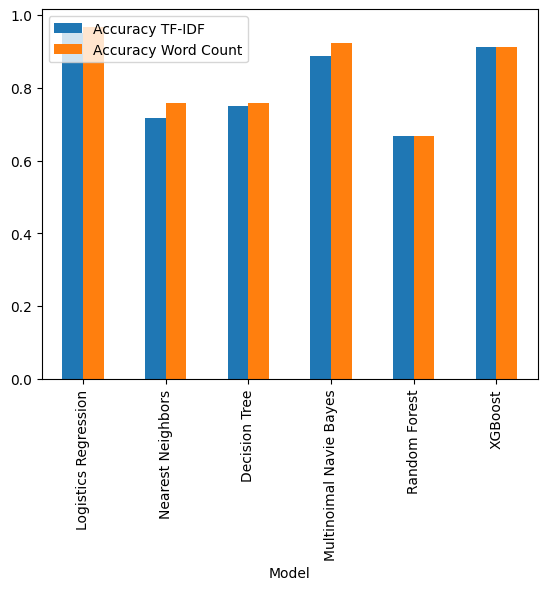

In [110]:
compare_df2.plot(x='Model', y=['Testing Accuracy_x','Testing Accuracy_y'], kind='bar', label=['Accuracy TF-IDF','Accuracy Word Count'])


<Axes: xlabel='Model'>

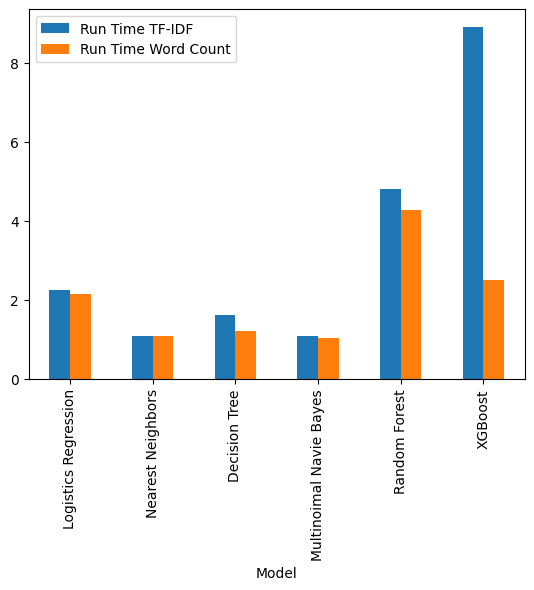

In [111]:
compare_df2.plot(x='Model', y=['Run Time_x','Run Time_y'], kind='bar', label=['Run Time TF-IDF','Run Time Word Count'])


#### Hyper Parameter Tunning

#### For this initial EDA, we will evaluate Logistics regression with TF-IDf and Multinomial Navie Bayes Word Count


In [121]:
# Lets tune the parameters for the 3 best models
Logistics_TF=CLF_List[0]
XGBoost_WC=CLF_List[11]


In [ ]:
# GridSearch for Logistics Regression
lr_params = {'tfidf__max_features': [100, 500, 1000,10000],
         'tfidf__stop_words': ['english', None],
         'classifiers__C': np.logspace(-4, 4, 5)
         }

grid_lr = GridSearchCV(Logistics_TF, param_grid=lr_params)
grid_lr.fit(X_train, y_train)
test_acc = grid_lr.score(X_test, y_test)


In [115]:
print('Logistics accuracy after tunning: '+ str( test_acc))

Logistics accuracy after tunning: 0.9127515139675718


In [140]:
grid_lr.best_params_

{'classifiers__C': 100.0,
 'tfidf__max_features': 10000,
 'tfidf__stop_words': 'english'}

In [135]:
# GridSearch for Multinomial Regression
xg_params = {'counttv__max_features': [100, 500, 1000],
         'counttv__stop_words': ['english'],
         'classifiers__max_depth': [2, 15],
         'classifiers__gamma': [1,4,9]
         
         }

grid_xg = GridSearchCV(XGBoost_WC, param_grid=xg_params)
grid_xg.fit(X_train, y_train)
test_acc_xg = grid_xg.score(X_test, y_test)


In [136]:
print('XGBoost accuracy after tunning: '+ str( test_acc_xg))

XGBoost accuracy after tunning: 0.9167317835514749


In [137]:
grid_xg.best_params_

{'classifiers__gamma': 4,
 'classifiers__max_depth': 15,
 'counttv__max_features': 1000,
 'counttv__stop_words': 'english'}